# Import necessary libraries and load the dataset

In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm  
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set_context("talk",  font_scale=0.6)

from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Load data
data_path = os.path.join("..", "data", "breast_cancer.csv")

# Load the data
data = pd.read_csv(data_path)

# Overview of the Data

In [4]:
data.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0   1         M        14.68         20.13           94.74      684.5   
1   2         B        11.50         18.45           73.28      407.4   
2   3         M        15.85         23.95          103.70      782.7   
3   4         M        18.82         21.97          123.70     1110.0   
4   5         B        12.95         16.02           83.14      513.7   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.09867           0.07200         0.07395              0.05259   
1          0.09345           0.05991         0.02638              0.02069   
2          0.08401           0.10020         0.09938              0.05364   
3          0.10180           0.13890         0.15940              0.08744   
4          0.10050           0.07943         0.06155              0.03370   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         19.07          30.88           123.40      1138.0   
1  ...         12.97          22.46            83.12       508.9   
2  ...         16.84          27.66           112.00       876.5   
3  ...         22.66          30.93           145.30      1603.0   
4  ...         13.74          19.93            88.81       585.4   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1464             0.1871          0.29140               0.16090   
1            0.1183             0.1049          0.08105               0.06544   
2            0.1131             0.1924          0.23220               0.11190   
3            0.1390             0.3463          0.39120               0.17080   
4            0.1483                NaN          0.22410               0.10560   

   symmetry_worst  fractal_dimension_worst  
0          0.3029                  0.08216  
1          0.2740                      NaN  
2          0.2809                  0.06287  
3          0.3007                  0.08314  
4          0.3380                  0.09584  

[5 rows x 32 columns]

# Basic Data Exploration

In [5]:
# Organize the EDA process in a function
def perform_eda(df, dataset_name):
    print(f"EDA for {dataset_name} dataset:")
    print("Dataset shape:", data.shape)
    print("\nMissing Values:")
    print(data.isnull().sum())
    print("\nDuplicates:")
    print(data.duplicated().sum())
    print("\nColumns:")
    print(data.columns.tolist())
    print("\nData Types:")
    print(data.dtypes)

In [6]:
perform_eda(data, "Breast Cancer")

EDA for Breast Cancer dataset:
Dataset shape: (512, 32)

Missing Values:
id                          0
diagnosis                   0
radius_mean                 7
texture_mean                5
perimeter_mean              5
area_mean                   4
smoothness_mean             6
compactness_mean            1
concavity_mean             10
concave points_mean         8
symmetry_mean               5
fractal_dimension_mean      3
radius_se                   2
texture_se                  7
perimeter_se                1
area_se                     3
smoothness_se               6
compactness_se              4
concavity_se                2
concave points_se           4
symmetry_se                 5
fractal_dimension_se        5
radius_worst                5
texture_worst               2
perimeter_worst             7
area_worst                  7
smoothness_worst            5
compactness_worst           9
concavity_worst             4
concave points_worst       11
symmetry_worst             

`Comment`

**Columns Data Types**

The only categorical column is the diagnosis one, which is our target. In order to handle it, we will have to convert it to numerical column, by encoding. 

**Duplicates**

There aren't any, so this step don't need anymore handling.

**Missing Values**

1. **Columns with most missing values**:
   - `concave points_worst` (11 missing)
   - `concavity_mean` (10 missing)
   - `concave points_mean` (8 missing)

2. **Columns with no missing values**:
   - `id`
   - `diagnosis` (target variable)

3. **Potential handling strategies**:
   - **Drop columns**
   - **Impute numerical columns** with median/mean

# Handling of Missing Values

In [7]:
# Option 1: Drop rows with missing values
data_dropna = data.dropna()

print(f"Rows dropped: {len(data) - len(data_dropna)}")

Rows dropped: 128


In [8]:
# Select numerical columns (exclude target)
target_col = "diagnosis"
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.drop(target_col, errors='ignore')

# Explore the skewness of the numerical features
print(data[numerical_cols].skew().sort_values())

id                         0.000000
smoothness_worst           0.452510
concave points_worst       0.507789
texture_worst              0.526639
smoothness_mean            0.554170
texture_mean               0.675581
symmetry_mean              0.734935
radius_mean                0.972923
perimeter_mean             1.012724
radius_worst               1.118917
perimeter_worst            1.128077
concavity_worst            1.184448
concave points_mean        1.197988
fractal_dimension_mean     1.198099
compactness_mean           1.250797
compactness_worst          1.450490
concavity_mean             1.450969
symmetry_worst             1.494522
concave points_se          1.520670
texture_se                 1.673497
area_mean                  1.689782
compactness_se             1.732378
fractal_dimension_worst    1.738221
area_worst                 1.872487
symmetry_se                2.288592
smoothness_se              2.405754
radius_se                  3.089150
perimeter_se               3

In [9]:
# Option 2: Impute missing values with median
data_imputed = data.copy()
imputer = SimpleImputer(strategy='median')
data_imputed[numerical_cols] = imputer.fit_transform(data_imputed[numerical_cols])

print(data_imputed[numerical_cols].isnull().sum())  # Should all be 0

id                         0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


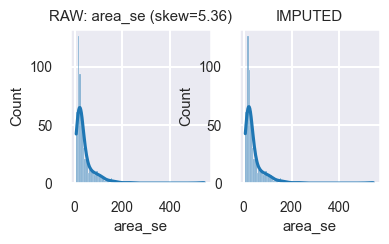

In [10]:
# Check the distribution of the 'area_se' feature before and after imputation to visualize the effect of the imputation with the median
plt.figure(figsize=(4, 2))
plt.subplot(1,2,1)
sns.histplot(data['area_se'], kde=True).set_title('RAW: area_se (skew=5.36)')
plt.subplot(1,2,2)
sns.histplot(data_imputed['area_se'], kde=True).set_title('IMPUTED')
plt.show()

`Comment`

**Handling Missing Values: Decision**

- **Drop NA:** Loses 128 samples (~45% of data)
- **Impute with median instead of mean:** 
    - Keeps full dataset without distort distributions
    - 24/30 features have skewness ≥ 0.5 and 14 features are extremely skewed (|skew| > 1)
    - Medical data often contains outliers

# Target Variable Analysis

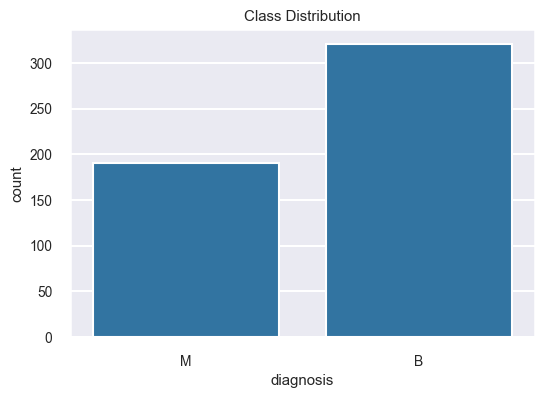

diagnosis
B    0.626953
M    0.373047
Name: proportion, dtype: float64


In [11]:
# Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=data_imputed, x=target_col)
plt.title("Class Distribution")
plt.show()

# Class balance
print(data[target_col].value_counts(normalize=True))

`Comment`

Not severely imbalanced, but still noteworthy.

**Potential Impact**:
   - Models may develop a slight bias toward predicting the majority class (Benign).
   - Evaluation metrics like accuracy could be misleading (e.g., a model that always predicts `B` would achieve 62.7% accuracy).

**Handling Strategies**
- **Evaluation Metrics**:
  - Prioritize **recall** (to minimize false negatives for malignant cases) and **F1-score** over raw accuracy.
  - Use confusion matrices for detailed analysis.

# Features Analysis

               id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  512.000000   512.000000    512.000000      512.000000   512.000000   
mean   256.500000    14.162975     19.359512       92.174395   656.766406   
std    147.945936     3.530510      4.293520       24.470606   355.839691   
min      1.000000     6.981000      9.710000       43.790000   143.500000   
25%    128.750000    11.732500     16.210000       75.267500   420.300000   
50%    256.500000    13.400000     18.890000       86.340000   548.750000   
75%    384.250000    15.757500     21.812500      103.875000   782.625000   
max    512.000000    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       512.000000        512.000000      512.000000           512.000000   
mean          0.096156          0.103601        0.087476             0.048651   
std           0.014124          0.053070        0.079529       

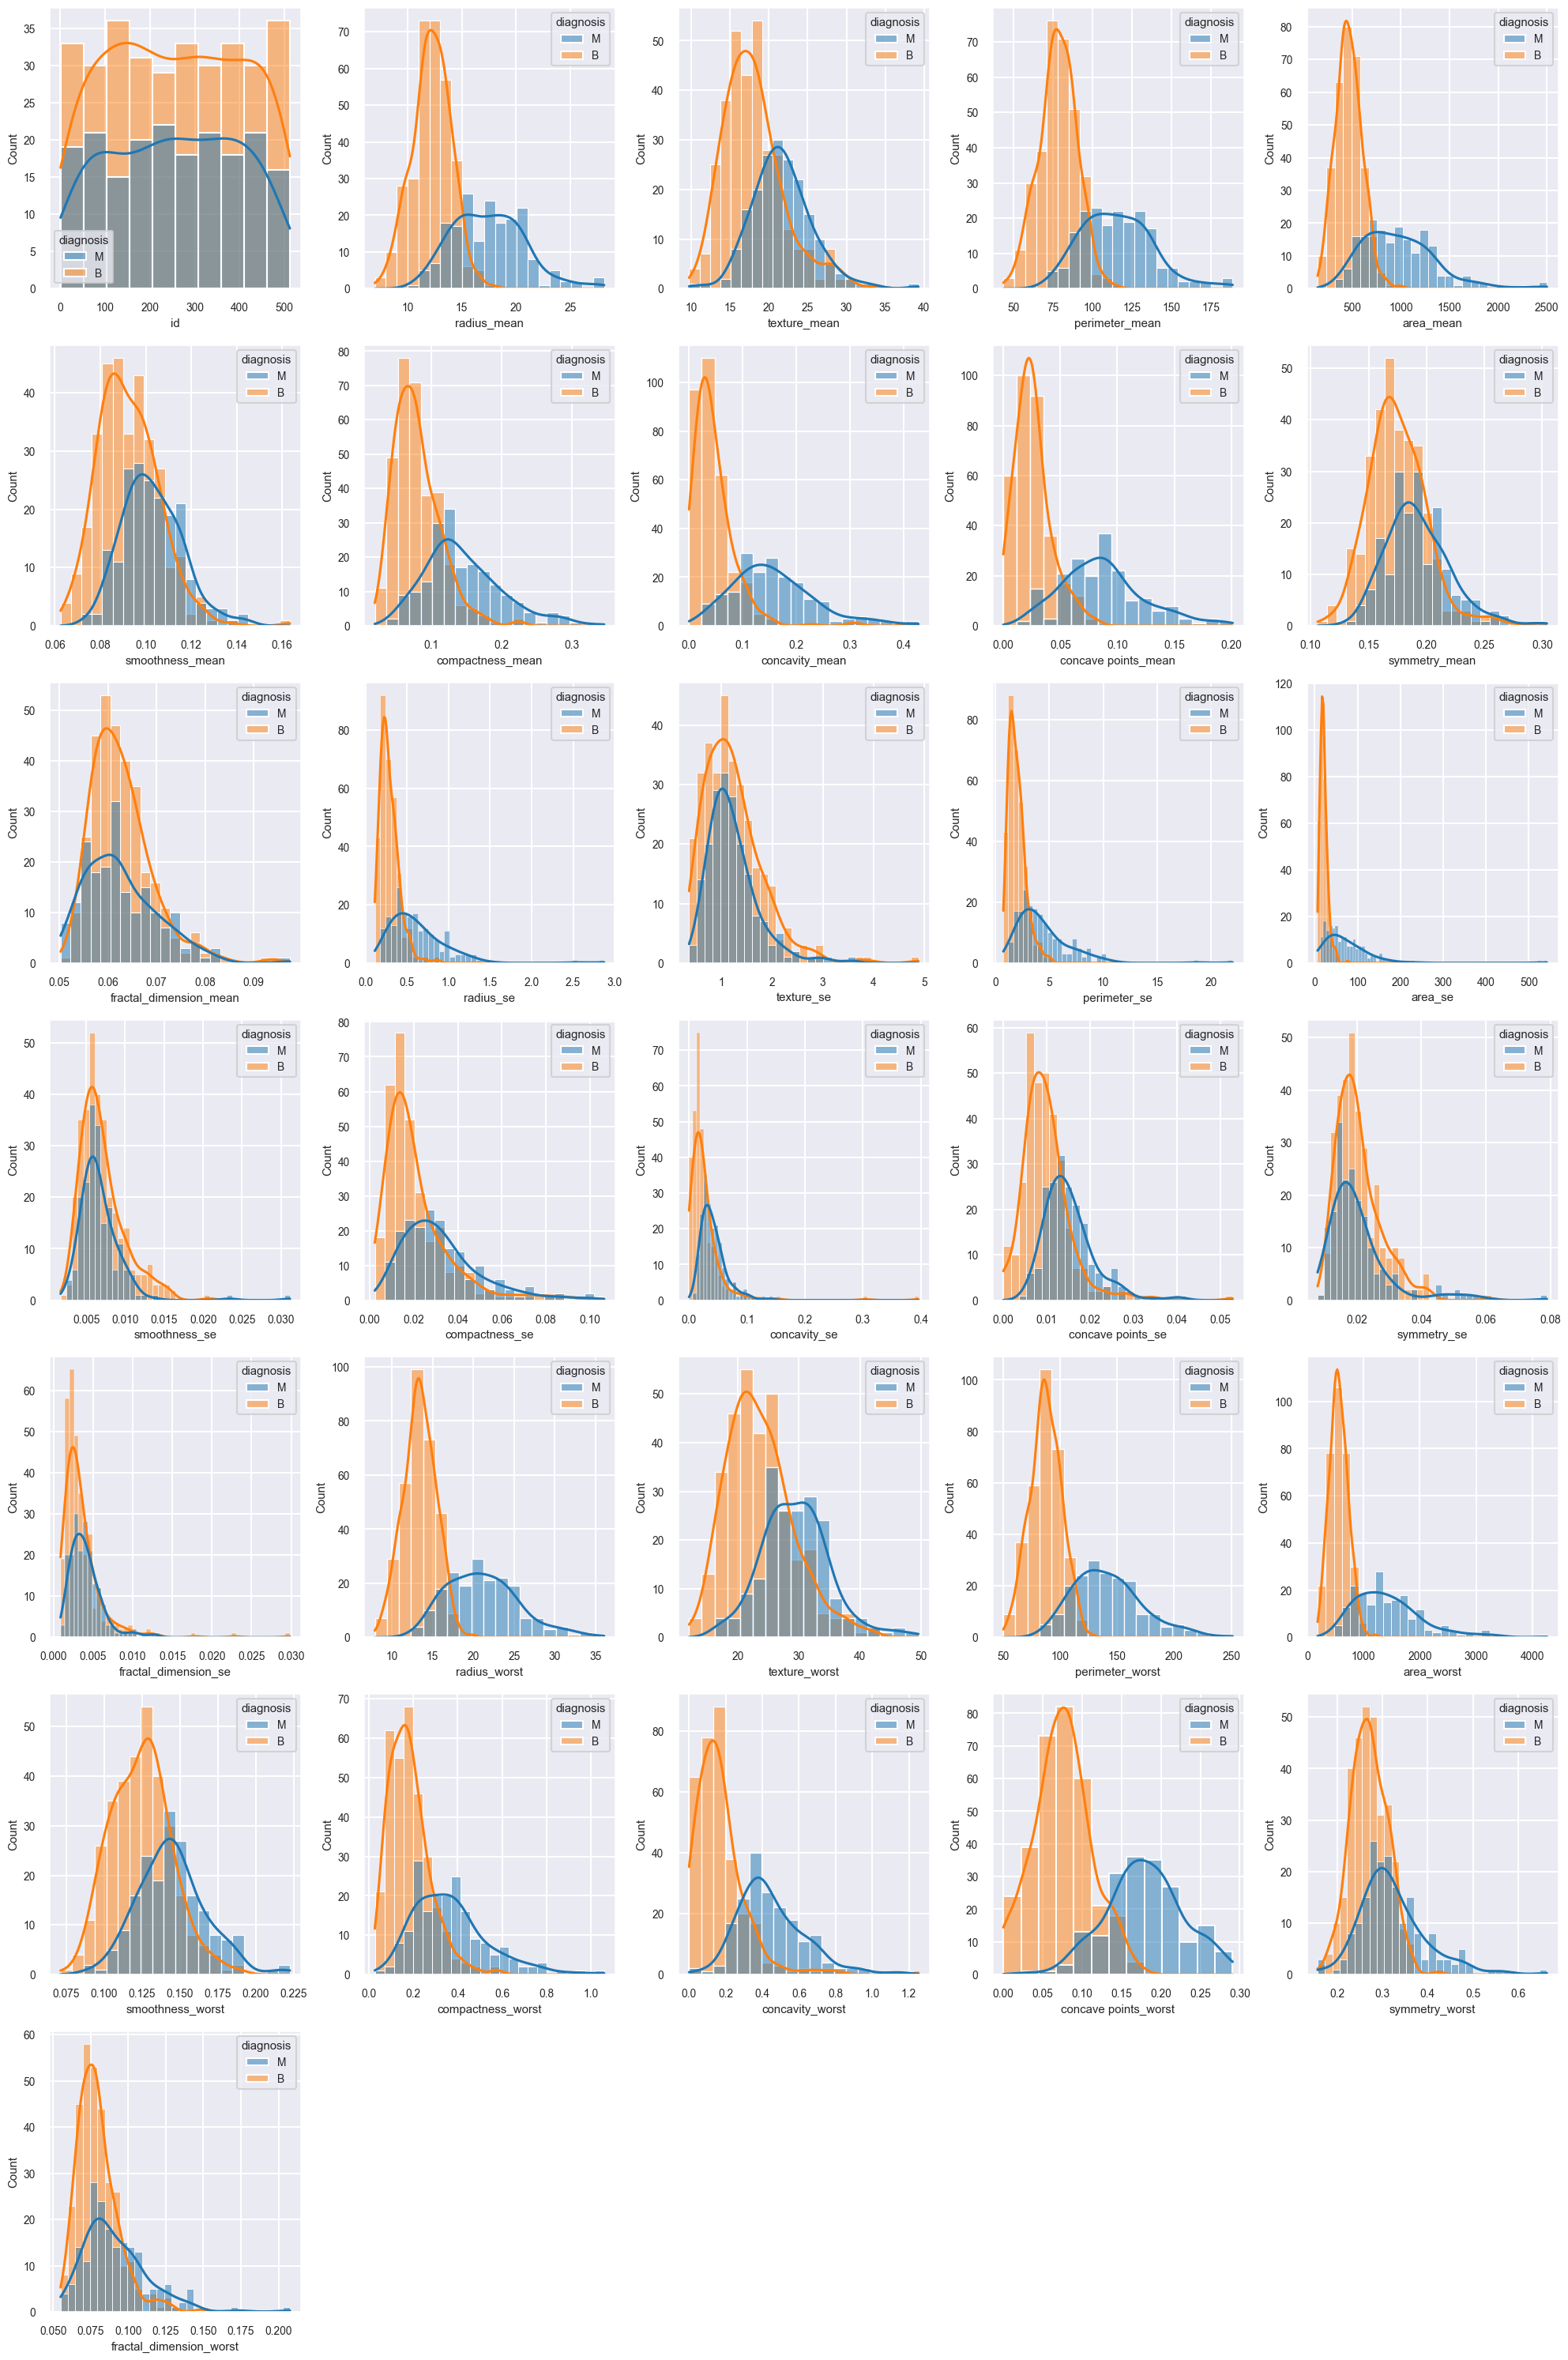

In [12]:
# Summary stats
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.drop(target_col, errors='ignore')
print(data_imputed[numerical_cols].describe())

# Plot distributions
plt.figure(figsize=(20, 30))
for i, col in enumerate(numerical_cols[:31]):
    plt.subplot(7, 5, i+1)
    sns.histplot(data=data_imputed, x=col, kde=True, hue=target_col if target_col in data_imputed else None)
plt.tight_layout()
plt.show()

In [13]:
# Get summary statistics by target class
print("\nSummary statistics by target class:")
grouped_data = data_imputed.groupby('diagnosis').describe()
print(grouped_data)


Summary statistics by target class:
              id                                                           \
           count        mean         std  min    25%    50%    75%    max   
diagnosis                                                                   
B          321.0  257.800623  150.023344  2.0  132.0  258.0  390.0  509.0   
M          191.0  254.314136  144.751532  1.0  125.0  255.0  379.0  512.0   

          radius_mean             ... symmetry_worst          \
                count       mean  ...            75%     max   
diagnosis                         ...                          
B               321.0  12.206178  ...         0.2983  0.4228   
M               191.0  17.451623  ...         0.3590  0.6638   

          fractal_dimension_worst                                         \
                            count      mean       std      min       25%   
diagnosis                                                                  
B                           

`Comment`

The histograms and summary statistics reveal a clear trend: Malignant (M) tumors tend to have larger values for most of the "mean," "worst," and even some "standard error" features compared to Benign (B) tumors. This is particularly noticeable in features like radius, texture, perimeter, area, smoothness, compactness, concavity, and concave points. The summary statistics broken down by diagnosis further confirm this, showing higher average values for these features in the Malignant group. These findings suggest that larger and more extreme characteristics of cell nuclei are strongly associated with malignancy in this dataset.

# Correlation Analysis

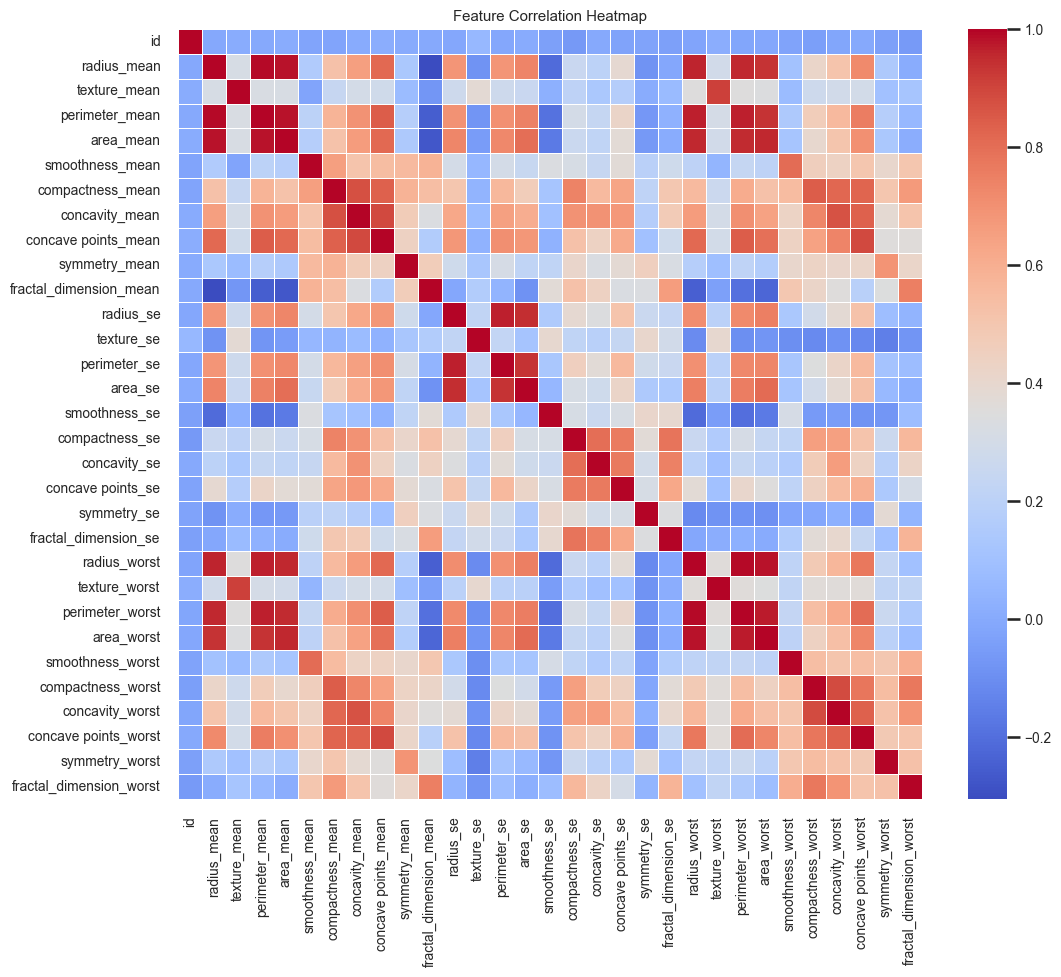

In [14]:
# Correlation matrix (numerical features only)
corr_matrix = data_imputed[numerical_cols].corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Top correlations with target (if target is numerical)
if target_col in numerical_cols:
    print("\nTop Correlations with Target:")
    print(corr_matrix[target_col].sort_values(ascending=False))

# Target Encoding

In [15]:
# Encode categorical features (target column)
def encode_target(df, target_col):
    if target_col in df.columns:
        df[target_col] = df[target_col].map({"M":1, "B":0})
    return df

data_imputed = encode_target(data_imputed, target_col)

# Verify encoding
print("Encoded Class Distribution:")
print(data_imputed[target_col].value_counts(normalize=True))

Encoded Class Distribution:
diagnosis
0    0.626953
1    0.373047
Name: proportion, dtype: float64


# Correlation with Target

In [16]:
corr_with_target = data_imputed.corr()[target_col].sort_values(ascending=False)
print("Top Correlations with Target:\n", corr_with_target)

Top Correlations with Target:
 diagnosis                  1.000000
perimeter_worst            0.777544
concave points_worst       0.776158
radius_worst               0.769723
concave points_mean        0.761292
perimeter_mean             0.737984
area_worst                 0.728995
radius_mean                0.719231
area_mean                  0.698950
concavity_mean             0.677479
concavity_worst            0.648649
compactness_mean           0.604189
compactness_worst          0.584377
radius_se                  0.564300
perimeter_se               0.558970
area_se                    0.544365
texture_worst              0.463517
smoothness_worst           0.426140
texture_mean               0.415027
symmetry_worst             0.413605
concave points_se          0.407977
smoothness_mean            0.357314
fractal_dimension_worst    0.323295
symmetry_mean              0.319602
compactness_se             0.310719
concavity_se               0.247670
fractal_dimension_se       0.0898

**Interpretation of Correlation Heatmap and Target Correlation:**

We observe strong positive correlations within groups of "mean," "worst," and to a lesser extent, "standard error" features (indicated by the red blocks). This suggests that if one feature in a group is high, the others in that group tend to be high as well.

The printed correlations with the 'diagnosis' target (where higher positive values likely indicate a stronger association with Malignant) show that features like `radius_worst`, `perimeter_worst`, `area_worst`, `radius_mean`, `perimeter_mean`, and `area_mean` have the highest positive correlation with the diagnosis. This reinforces the earlier observation that larger sizes and extents of the tumor tend to be associated with malignancy. Conversely, `fractal_dimension_se` and `fractal_dimension_mean` show a weak negative correlation.

<Figure size 1500x1500 with 0 Axes>

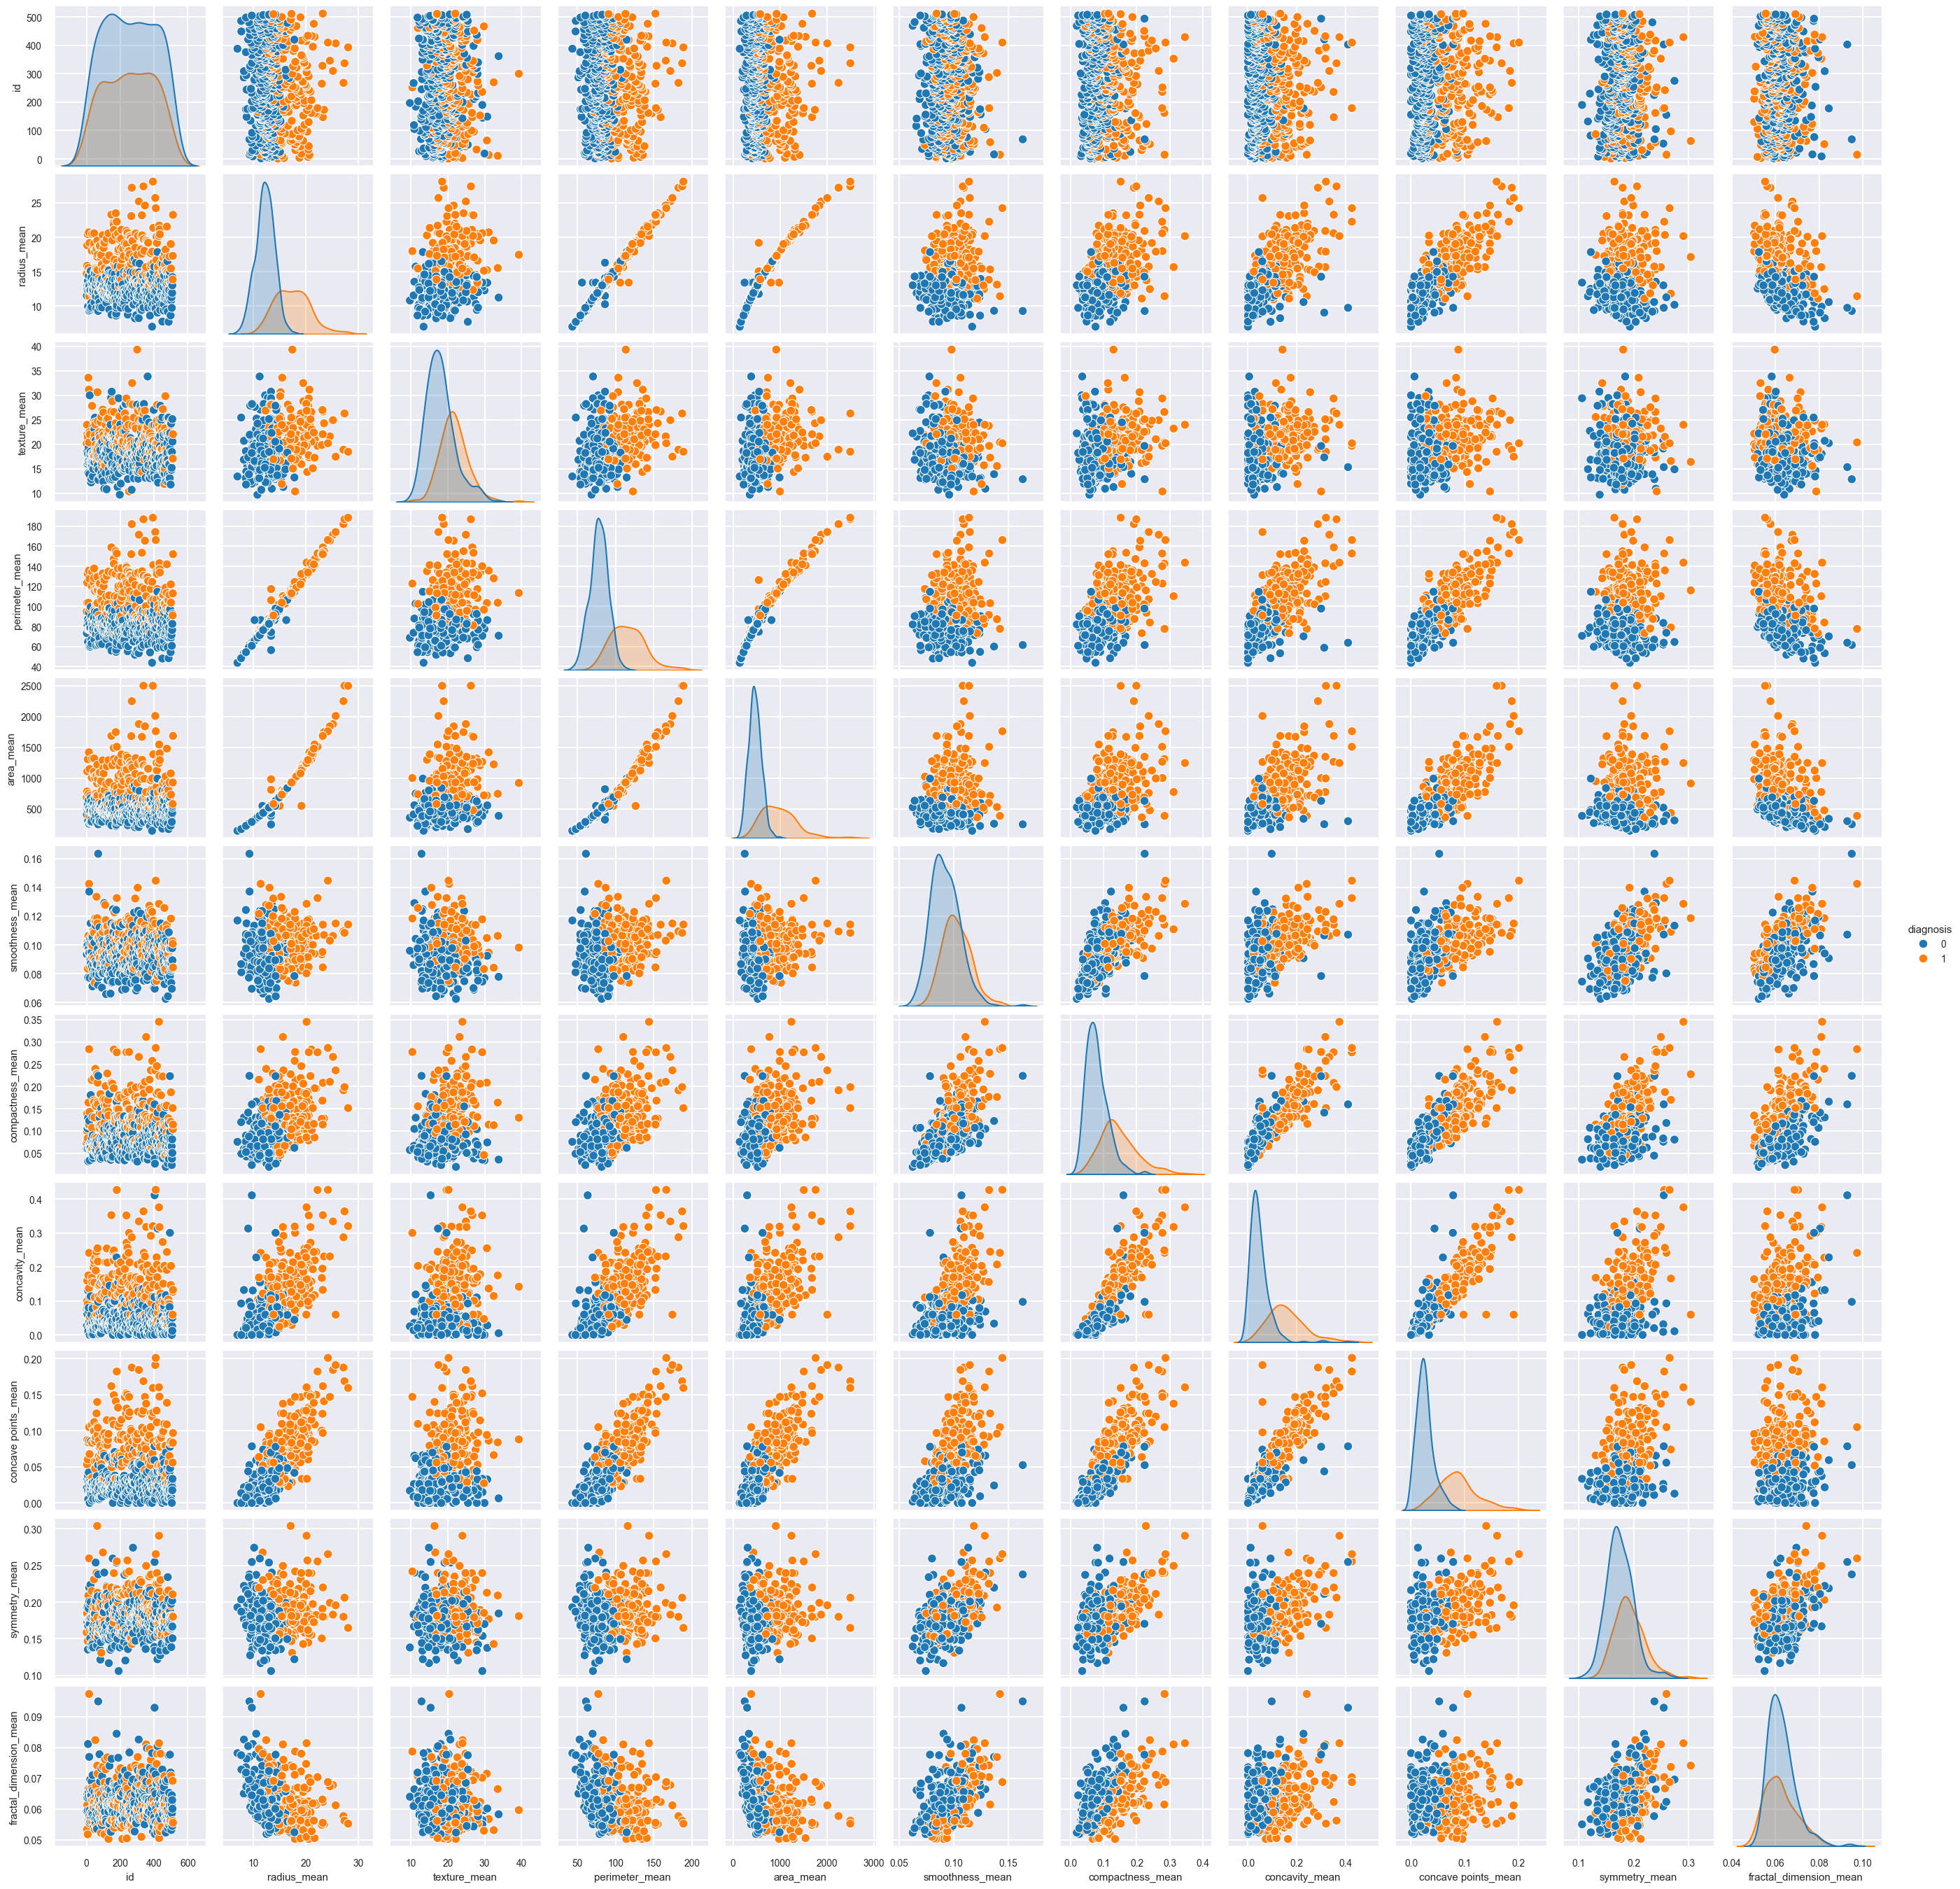

In [17]:
plt.figure(figsize=(15, 15))
sns.pairplot(data=data_imputed, vars=numerical_cols[:11], hue=target_col)
plt.show()

`Comment`

**Interpretation of Pair Plots:**

The pair plots provide a visual representation of the relationships between multiple features simultaneously, colored by the diagnosis (Benign in blue, Malignant in orange).

* **Diagonal:** The diagonal shows the distribution of each individual feature for both Benign and Malignant cases. This reinforces our earlier observations from the histograms, showing that for many "mean" and related features (like radius, texture, perimeter, area, etc.), the distribution for Malignant tumors is shifted towards higher values.

* **Off-Diagonal:** The off-diagonal plots show the scatter plots between pairs of features, again colored by diagnosis. These plots help visualize how features interact and whether there are any clear separations between the two diagnosis groups in the multi-dimensional feature space.

    * We can see positive correlations between many pairs of "mean" features (e.g., radius vs. perimeter, area vs. radius), as the points tend to form upward-sloping patterns.
    * For several feature pairs, there appears to be a reasonable degree of separation between the blue (Benign) and orange (Malignant) points, suggesting that these combinations of features can be useful in distinguishing between the two diagnoses. For instance, plotting radius against area shows a tendency for Malignant tumors to have both larger radii and larger areas.
    * The degree of overlap between the blue and orange points varies across different feature pairs, indicating that some features are better at separating the classes than others when considered in pairs.

# Outliers Detection

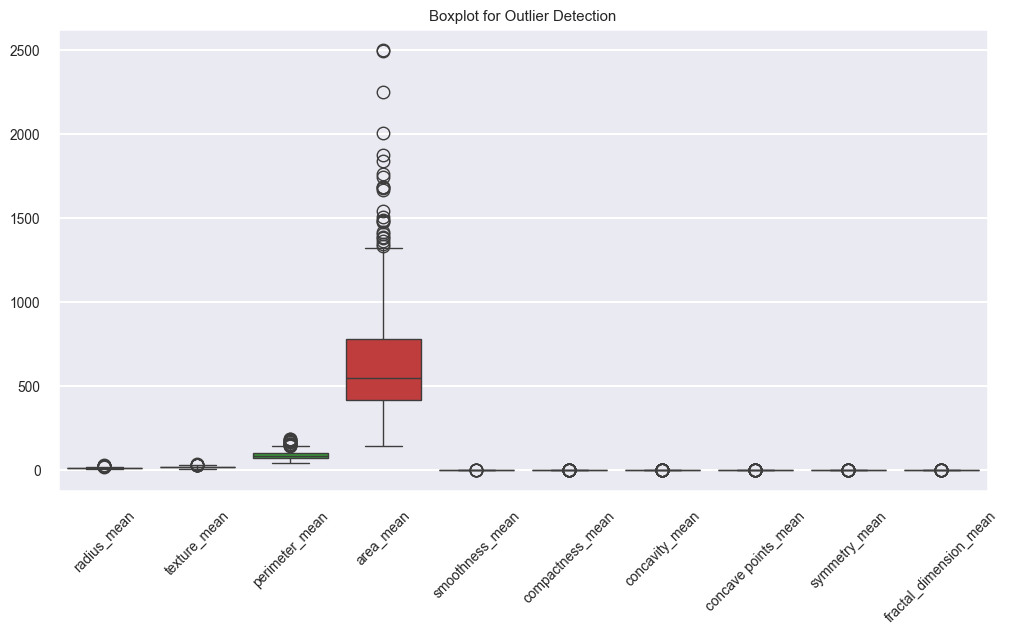

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_imputed[numerical_cols[1:11]])
plt.title("Boxplot for Outlier Detection")
plt.xticks(rotation=45)
plt.show()

* **'area_mean'**: This feature shows a significant number of potential high outliers, extending far beyond the upper whisker. This suggests there are some tumors with exceptionally large areas compared to the majority.

* **'perimeter_mean'**: This feature also exhibits some potential high outliers, although fewer and less extreme than 'area_mean'.

* **Other features**: Features like 'radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', and 'fractal_dimension_mean' show relatively few or no apparent outliers based on this visualization.

These box plots are useful for identifying features where extreme values might need further investigation or consideration during data preprocessing and modeling. The presence of outliers, especially in features strongly correlated with the target variable, could potentially influence model performance.

## Dimensionality Reduction

/Users/dvoulgari/Desktop/MLCB/Ass2/Ass2_venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/dvoulgari/Desktop/MLCB/Ass2/Ass2_venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/dvoulgari/Desktop/MLCB/Ass2/Ass2_venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


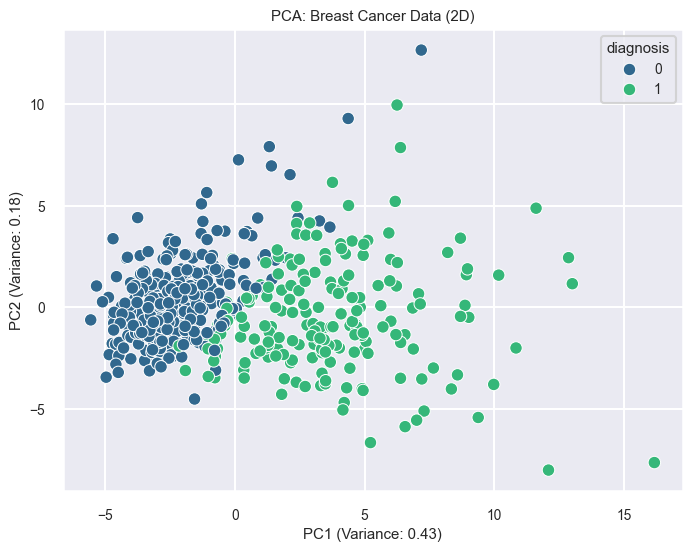

In [19]:
# Separate features (X) and target (y)
X = data_imputed.drop(columns=['diagnosis'])
y = data_imputed['diagnosis']

# Scale features (critical for PCA/t-SNE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['diagnosis'] = y 

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='diagnosis', palette='viridis')
plt.title("PCA: Breast Cancer Data (2D)")
plt.xlabel(f"PC1 (Variance: {pca.explained_variance_ratio_[0]:.2f})")
plt.ylabel(f"PC2 (Variance: {pca.explained_variance_ratio_[1]:.2f})")
plt.show()

In [20]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.42684128 0.17740805]


**Interpretation of PCA Results (2D Scatter Plot and Explained Variance):**

The scatter plot shows the breast cancer data projected onto the first two principal components (PC1 and PC2) after applying Principal Component Analysis (PCA). Each point represents a sample, colored by the diagnosis (0 for Benign, 1 for Malignant).

* **Separation:** We observe a noticeable separation between the Benign (blue) and Malignant (green) clusters in this 2D space. While there is some overlap, particularly in the central region, the Malignant samples tend to be more spread out along PC1, generally having higher values. This suggests that the first two principal components capture a significant portion of the variance that distinguishes between the two diagnoses.

* **Explained Variance Ratio:** The printed `explained_variance_ratio_` tells us the proportion of the total variance in the original data that is explained by each principal component. The values provided (e.g., `[0.43, 0.18]`) indicate that the first principal component (PC1) explains 43% of the variance, and the second principal component (PC2) explains 18% of the variance. Together, the first two principal components capture $43\% + 18\% = 61\%$ of the total variance in the original features. This confirms that these two components provide a reasonably good low-dimensional representation of the data while still retaining a substantial amount of the information relevant to the diagnosis.